### HighIQ spectral processing example.

This notebook shows an example of how to process Doppler spectra from complex autocorrelation function (ACF) data. The example data in this notebook are from the Atmospheric Radiation Measurement program's Doppler Lidar in the Southern Great Plains site in Oklahoma. 

In [1]:
import highiq
import act
import xarray as xr
from datetime import datetime
%pylab inline

/Users/rjackson/HighIQ/highiq/calc/moments.py:9: Warning: Jax not installed...reverting to Numpy!
  warnings.warn("Jax not installed...reverting to Numpy!", Warning)
/Users/rjackson/HighIQ/highiq/calc/spectra.py:9: Warning: CuPy not installed...reverting to Numpy!
  warnings.warn("CuPy not installed...reverting to Numpy!", Warning)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


This example shows how to process moments for a doppler lidar file from the ARM SGP site. The below example file is available at:
    
https://drive.google.com/uc?export=download&id=1x7pT4K05wJufepBR_26N1wpLzCoEEr9H

In [2]:
file_path = '/Users/rjackson/aet_RHI_240_20230815_060722.raw'
home_point = 'atmos.homepoint'

HighIQ uses xarray as its basic data model. Therefore, if you have ACF data in netCDF format, HighIQ will be able to load it without any preprocessing steps. The input dataset must contain 2 four dimensional arrays where the dimensions represent (time, number of samples, number of lags, and real/complex component) such as in the example dataset below.

In [39]:
my_ds = highiq.io.read_00_data(file_path, home_point)

/Users/rjackson/aet
RHI
240
20230815
060722


In [40]:
my_ds

<xarray.Dataset>
Dimensions:    (time: 91, nsamples: 4000, nlags: 20, complex: 2)
Coordinates:
  * time       (time) datetime64[ns] 2023-08-15T06:07:27.320000 ... 2023-08-1...
Dimensions without coordinates: nsamples, nlags, complex
Data variables:
    acf        (time, nsamples, nlags, complex) float32 4.634e+05 ... 3.067e+04
    acf_bkg    (nsamples, nlags, complex) float32 4.329e+05 0.0 ... 7.123e+03
    aziumth    (time) float32 340.0 340.0 340.0 340.0 ... 340.0 340.0 340.0
    elevation  (time) float32 -0.0 2.033 4.025 6.013 ... 174.0 176.0 178.0 180.0
Attributes:
    dlon:                -87.9789
    dlat:                41.7883
    target_latitude:     41.7883
    target_longitude:    -87.9789
    target_altitude:     213.0
    home_point_azimuth:  0.0
    sample_rate:         50 MHz
    wavelength:          1548 nm

The first step with this dataset is to process the doppler spectra from the ACF data. HighIQ makes this easy given you have an xarray dataset that has similar specifications to the dataset above. 

In [ ]:
ds = highiq.calc.get_psd(my_ds, nfft=1024, time_window=1)

## Plotting power spectra

Power spectra then can be plotting using the standard .sel and .plot() commands that are built into xarray.
For example, if we want to pick out a certain range and time to plot the power spectra at, we can
simply use the below code.

<xarray.Dataset>
Dimensions:    (time: 3, nsamples: 4000, nlags: 20, complex: 2)
Coordinates:
  * time       (time) datetime64[ns] 2023-08-15T06:07:00 ... 2023-08-15T06:09:00
Dimensions without coordinates: nsamples, nlags, complex
Data variables:
    acf        (time, nsamples, nlags, complex) float32 3.689e+05 ... 3.067e+04
    acf_bkg    (time, nsamples, nlags, complex) float32 4.329e+05 ... 7.123e+03
    aziumth    (time) float32 340.0 340.0 340.0
    elevation  (time) float32 31.02 121.0 180.0
Attributes:
    dlon:                -87.9789
    dlat:                41.7883
    target_latitude:     41.7883
    target_longitude:    -87.9789
    target_altitude:     213.0
    home_point_azimuth:  0.0
    sample_rate:         50 MHz
    wavelength:          1548 nm

In [31]:
ds = highiq.calc.get_lidar_moments(ds)

/Users/rjackson/HighIQ/highiq/calc/moments.py:42: RuntimeWarning: divide by zero encountered in divide
  gpu_array = 1 / power_array * cp.sum(gpu_array * vel_bins_tiled, axis=2)
/Users/rjackson/HighIQ/highiq/calc/moments.py:42: RuntimeWarning: invalid value encountered in multiply
  gpu_array = 1 / power_array * cp.sum(gpu_array * vel_bins_tiled, axis=2)
/Users/rjackson/HighIQ/highiq/calc/moments.py:73: RuntimeWarning: divide by zero encountered in divide
  gpu_array = cp.sqrt(1 / power_array * cp.sum(
/Users/rjackson/HighIQ/highiq/calc/moments.py:73: RuntimeWarning: invalid value encountered in sqrt
  gpu_array = cp.sqrt(1 / power_array * cp.sum(


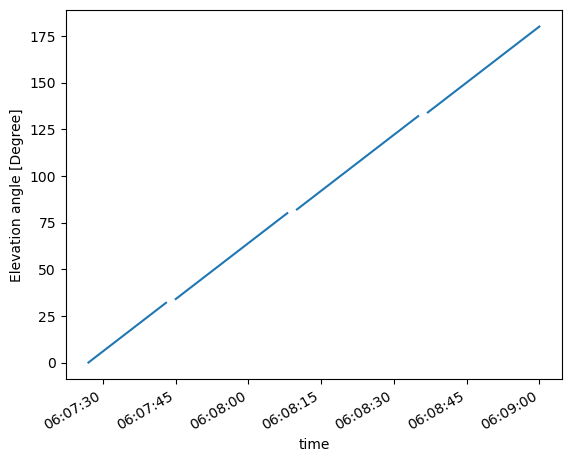

In [33]:
ds['elevation'].plot()

/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


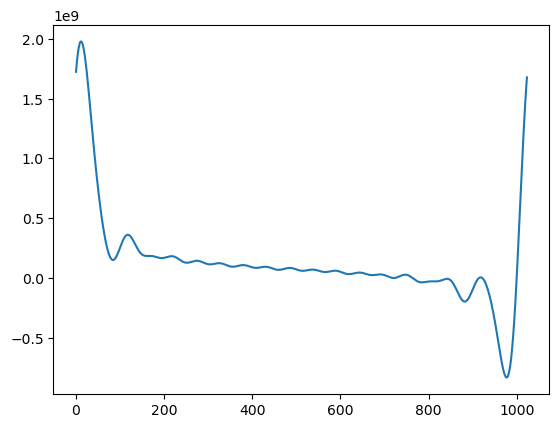

In [26]:
acf = ds['acf']
acf = acf[:, :, 0] + acf[:, :, 1] * 1j
#acf = np.pad(np.concatenate([acf[:, :, -1:0:-1], acf[:, :, :]], axis=2), ((0, 0), (0, 0), (512-20, 512+20)))
plt.plot(np.fft.fft(np.sum(acf[0, 90:110, :], axis=1), n=1024))

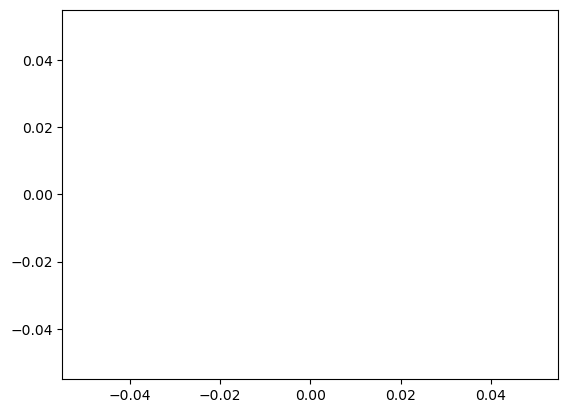

In [27]:
plt.plot(acf[60, 60, 400:600])

Notice how the power spectra are not very smooth. This is because "power_spectra_normed" contains
the data points in the power spectra without any interpolation. We can use interpolation to create smoother
power spectra that provide greater numerical stability.

In [8]:
ds["power"].isel(time=2, range=18).plot()
ds["power_bkg"].isel(time=2, range=18).plot()

KeyError: 'power'

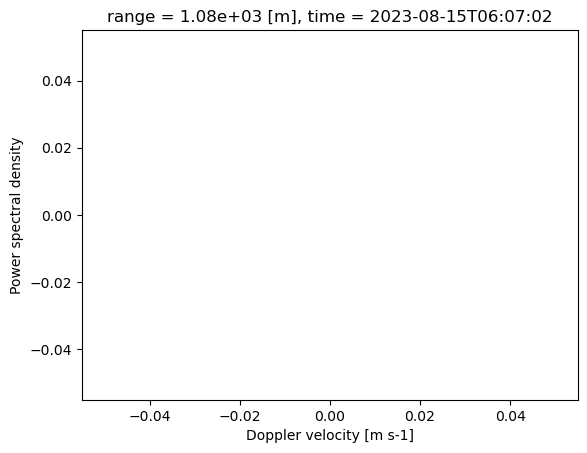

In [17]:
ds["power_spectral_density"].isel(time=2, range=18).plot()

The final step is to retrieve the lidar moments from the Doppler spectra. HighIQ makes this an easy step. All of the standard lidar moments (intensity, doppler velocity, spectral width, skewness, and kurtosis) can be retrieved using highiq.calc.get_lidar_moments. This must be done after the Doppler spectra are calculated.

In [35]:
my_ds = highiq.calc.get_lidar_moments(ds)
my_ds

/Users/rjackson/HighIQ/highiq/calc/moments.py:42: RuntimeWarning: divide by zero encountered in divide
  gpu_array = 1 / power_array * cp.sum(gpu_array * vel_bins_tiled, axis=2)
/Users/rjackson/HighIQ/highiq/calc/moments.py:42: RuntimeWarning: invalid value encountered in multiply
  gpu_array = 1 / power_array * cp.sum(gpu_array * vel_bins_tiled, axis=2)
/Users/rjackson/HighIQ/highiq/calc/moments.py:73: RuntimeWarning: divide by zero encountered in divide
  gpu_array = cp.sqrt(1 / power_array * cp.sum(
/Users/rjackson/HighIQ/highiq/calc/moments.py:73: RuntimeWarning: invalid value encountered in sqrt
  gpu_array = cp.sqrt(1 / power_array * cp.sum(


<xarray.Dataset>
Dimensions:                    (time: 94, nsamples: 4000, nlags: 20,
                                complex: 2, freq: 1024, vel_bins: 1024,
                                range: 200)
Coordinates:
  * time                       (time) datetime64[ns] 2023-08-15T06:07:27 ... ...
  * vel_bins                   (vel_bins) float64 -19.35 -19.31 ... 19.27 19.31
  * range                      (range) float64 0.0 60.0 ... 1.188e+04 1.194e+04
Dimensions without coordinates: nsamples, nlags, complex, freq
Data variables:
    acf                        (time, nsamples, nlags, complex) float32 4.634...
    acf_bkg                    (time, nsamples, nlags, complex) float32 4.329...
    aziumth                    (time) float32 340.0 340.0 340.0 ... 340.0 340.0
    elevation                  (time) float32 0.0 2.033 4.025 ... 178.0 180.0
    freq_bins                  (freq) float64 -2.5e+07 -2.495e+07 ... 2.495e+07
    power_spectral_density     (time, range, vel_bins) float64 1.095 ... 0.9979
    intensity                  (time, range) float64 1.06 1.198 ... 1.005 1.008
    doppler_velocity_max_peak  (time, range) float32 -1.89 -0.3779 ... 3.666
    doppler_velocity           (time, range) float64 1.757 1.803 ... 80.74 79.57
    spectral_width             (time, range) float64 58.06 38.45 ... 404.5 398.0
    skewness                   (time, range) float64 -0.08702 ... -0.2007
    kurtosis                   (time, range) float64 0.0701 0.1508 ... 0.04113
Attributes:
    dlon:                -87.9789
    dlat:                41.7883
    target_latitude:     41.7883
    target_longitude:    -87.9789
    target_altitude:     213.0
    home_point_azimuth:  0.0
    sample_rate:         50 MHz
    wavelength:          1548 nm
    nyquist_velocity:    19.350000 m s-1
    intensity_mask:      0.000000

Finally, we are able to plot our results. With just a few lines of code, HighIQ can leverage the existing plotting
routines in the Atmospheric Community Toolkit (ACT), available at https://anl-digr.github.io/ACT, in order to make high quality plots.

/Users/rjackson/ACT/act/plotting/plot.py:81: UserWarning: Could not discern datastreamname and dict or tuple were not provided. Using defaultname of act_datastream!
  warnings.warn(


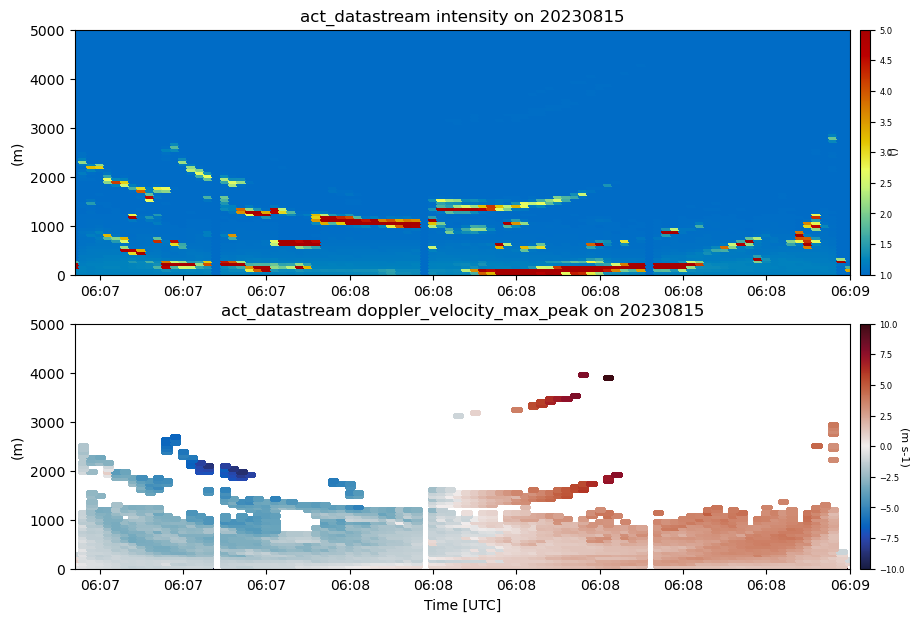

In [38]:
# Make a stricter mask for Doppler velocity to favor excluding more noise
my_ds['doppler_velocity_max_peak'] = my_ds['doppler_velocity_max_peak'].where(
    my_ds.intensity > 1.0008)

# With ACT, we set up a TimeSeriesDisplay object with two sub plots
my_display = act.plotting.TimeSeriesDisplay(my_ds, figsize=(10,7), subplot_shape=(2,))

# The plot function takes in the same kwargs as matplotlib's plotting routines
my_display.plot('intensity', subplot_index=(0,), cmap='HomeyerRainbow', vmin=1, vmax=5)
my_display.plot('doppler_velocity_max_peak', subplot_index=(1,), cmap='balance', vmin=-10, vmax=10)
my_display.set_yrng([0, 5000], subplot_index=(0,))
my_display.set_yrng([0, 5000], subplot_index=(1,))
my_display.fig.savefig('spectra_difference.png', dpi=300)

<xarray.DataArray 'time' (time: 571)>
array(['2022-01-07T14:01:07.000000000', '2022-01-07T14:04:29.000000000',
       '2022-01-07T14:04:52.000000000', ..., '2022-01-19T01:05:32.999998000',
       '2022-01-19T01:05:55.999998000', '2022-01-19T01:07:48.999998000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-01-07T14:01:07 ... 2022-01-19T01:07:4...